# Import Data

In [1]:
# helper.py
from helper import *

# read in the data
root = 'data/'
data = pl.read_parquet(root + 'train_series.parquet')
events = pl.read_csv(root + 'train_events.csv')
test = pl.read_parquet(root + 'test_series.parquet')

# view head
data.head()

series_id,step,timestamp,anglez,enmo
str,u32,str,f32,f32
"""038441c925bb""",0,"""2018-08-14T15:30:00-0400""",2.6367,0.0217
"""038441c925bb""",1,"""2018-08-14T15:30:05-0400""",2.6368,0.0215
"""038441c925bb""",2,"""2018-08-14T15:30:10-0400""",2.637,0.0216
"""038441c925bb""",3,"""2018-08-14T15:30:15-0400""",2.6368,0.0213
"""038441c925bb""",4,"""2018-08-14T15:30:20-0400""",2.6368,0.0215


- <ins>series_id</ins>: unique id for each user
- <ins>step</ins>: time step (0 is moment that user began using device) 
- <ins>timestamp</ins>: time of event
- <ins>anglez</ins>: "z-angle". Angle of arm relative to the vertical axis of the body
- <ins>enmo</ins>: quantifies physical activity. Very low values (close to 0) indicate sleep or rest

In [2]:
# print unique series_id
print(f'{data["series_id"].n_unique()} unique series_id')

# show the shape and nulls
show_shape_and_nulls(data)

277 unique series_id
Shape: (127946340, 5)
Null values:


series_id,step,timestamp,anglez,enmo
u32,u32,u32,u32,u32
0,0,0,0,0


- __127m__ rows (no nulls) where each row represents a user at a 5-second interval.
- 277 unique users in the data.

In [3]:
# view head
events.head()

series_id,night,event,step,timestamp
str,i64,str,i64,str
"""038441c925bb""",1,"""onset""",4992,"""2018-08-14T22:26:00-0400"""
"""038441c925bb""",1,"""wakeup""",10932,"""2018-08-15T06:41:00-0400"""
"""038441c925bb""",2,"""onset""",20244,"""2018-08-15T19:37:00-0400"""
"""038441c925bb""",2,"""wakeup""",27492,"""2018-08-16T05:41:00-0400"""
"""038441c925bb""",3,"""onset""",39996,"""2018-08-16T23:03:00-0400"""


__Events__ are the labels, where we have the onset and wakeup events for every night for each user.

In [4]:
# print unique series_id
print(f'{events["series_id"].n_unique()} unique series_id')

# show the shape and nulls
show_shape_and_nulls(events)

277 unique series_id
Shape: (14508, 5)
Null values:


series_id,night,event,step,timestamp
u32,u32,u32,u32,u32
0,0,0,4923,4923


- __14.5k rows__ (7254 total days). Half are onset times, half are wakeup times.
- Null values in the step and timestamp cols indicate that no sleep was detected (device wasn't worn).

# Clean Events

In [5]:
# look at non null events and values of events
non_null_events = events.filter(~pl.any_horizontal(pl.all().is_null()))
non_null_events['event'].value_counts()

event,count
str,u32
"""wakeup""",4794
"""onset""",4791


- There are 3 more wakeup events than onsets. Let's check for all of the instances in which there wasn't an (onset, wakeup) pair, and drop these from our data.

In [2]:
# create (onsent, wakeup) pairs
pairs = (events.pivot(values="step", index=["series_id", "night"], on="event"))

# filter the pairs for rows where exactly one of the two is null
faulty_pairs = pairs.filter((pl.col("onset").is_null() & pl.col("wakeup").is_not_null()) | (pl.col("onset").is_not_null() & pl.col("wakeup").is_null()))

# view
faulty_pairs

series_id,night,onset,wakeup
str,i64,i64,i64
"""0ce74d6d2106""",20,332376,null
"""154fe824ed87""",30,null,514980
"""44a41bba1ee7""",10,null,165684
"""efbfc4526d58""",7,null,114864
"""f8a8da8bdd00""",17,null,291384


- There is 1 instance of a user recording an onset event with no wakeup, and then 4 events where a wakeup was recorded with no onset.
- Having mismatched pairs will make the modeling process tricker, so I will fill in each of the (series_id, night) pairs with null values in the "step" and "timestamp" columns.

In [3]:
# iterate through faulty_pairs['series_id', 'night'] and index into events
for series_id, night in zip(faulty_pairs['series_id'], faulty_pairs['night']):
    # fill all "step" and "timestamp" values with null
    events = events.with_columns(
        pl.when((pl.col('series_id') == series_id) & (pl.col('night') == night)).then(None).otherwise(pl.col('step')).alias('step'),
        pl.when((pl.col('series_id') == series_id) & (pl.col('night') == night)).then(None).otherwise(pl.col('timestamp')).alias('timestamp'))

# check again for mismatches
pairs = (events.pivot(values="step", index=["series_id", "night"], on="event"))
faulty_pairs = pairs.filter((pl.col("onset").is_null() & pl.col("wakeup").is_not_null()) | (pl.col("onset").is_not_null() & pl.col("wakeup").is_null()))
faulty_pairs

series_id,night,onset,wakeup
str,i64,i64,i64


# Timestamp

In [4]:
# add date cols
data = add_date_cols(data)
events = add_date_cols(events)
test = add_date_cols(test)

# check range of dates
events.filter(pl.col('date').is_not_null())['date'].min(), events.filter(pl.col('date').is_not_null())['date'].max()

(datetime.date(2017, 8, 5), datetime.date(2019, 7, 5))

- Dates range from August 5th, 2017 - July 5th, 2019.

,0,1,2,3,4,5,6,7,8
statistic,count,null_count,mean,std,min,25%,50%,75%,max
tot_recorded_nights,277.0,0.0,17.310469,8.674321,0.0,11.0,19.0,23.0,35.0


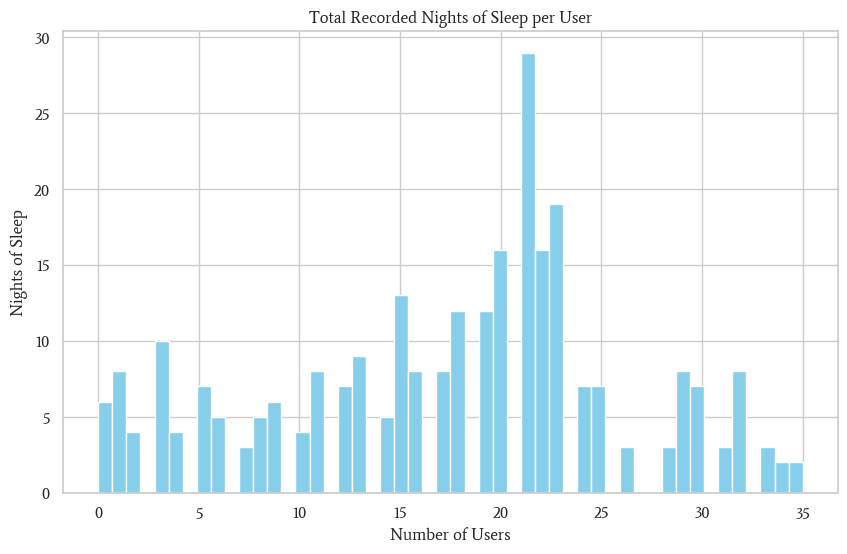

In [9]:
# create the missing_sleep column: True if step is missing, else False
events = events.with_columns([
    (pl.col('step').is_null()).alias('missing_event')
])

# group by series_id and aggregate in one pass
aggregated = events.group_by('series_id').agg([
    pl.count('event').alias('tot_events'),
    pl.last('night').alias('tot_nights'),
    pl.sum('missing_event').alias('tot_missing_events')
])

# divide total_missing_sleep by 2 (using integer division) to get tot_missing_nights.
aggregated = aggregated.with_columns([
    (pl.col('tot_missing_events') // 2).cast(pl.Int32).alias('tot_missing_nights')
])

# add tot_recorded_events and tot_recorded_nights columns
aggregated = aggregated.with_columns([
    (pl.col('tot_events') - pl.col('tot_missing_events')).alias('tot_recorded_events'),
    (pl.col('tot_nights') - pl.col('tot_missing_nights')).alias('tot_recorded_nights')
])

# plot nights of sleep per user
fig, ax = plt.subplots(figsize=(10, 6))
aggregated['tot_recorded_nights'].to_pandas().hist(bins=50, ax=ax, color='skyblue')
ax.set_title('Total Recorded Nights of Sleep per User')
ax.set_ylabel('Nights of Sleep')
ax.set_xlabel('Number of Users')

# describe
aggregated[['tot_recorded_nights']].describe().to_pandas().T

- Each user had about 15-16 nights of recorded sleep.

,0,1,2,3,4,5,6,7,8
statistic,count,null_count,mean,std,min,25%,50%,75%,max
tot_missing_nights,277.0,0.0,8.895307,10.439606,0.0,2.0,5.0,13.0,72.0


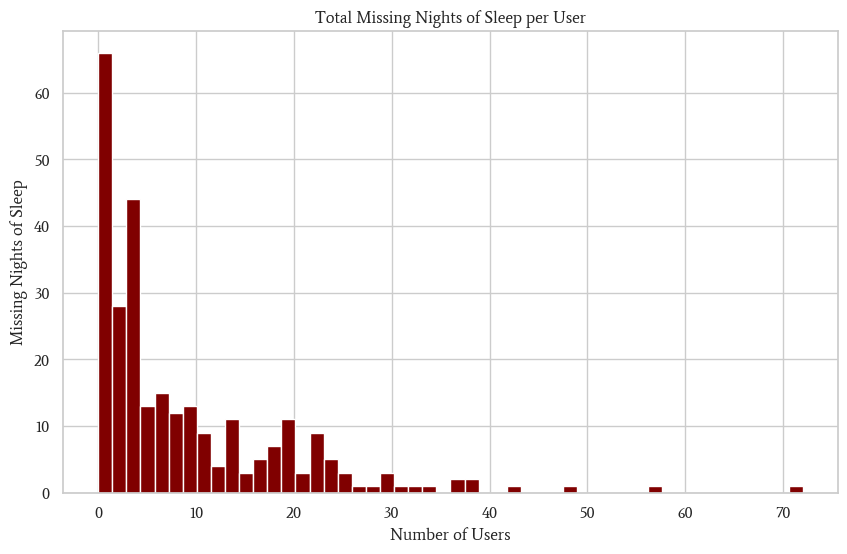

In [10]:
# plot missing nights of sleep per user
fig, ax = plt.subplots(figsize=(10, 6))
aggregated['tot_missing_nights'].to_pandas().hist(bins=50, ax=ax, color='maroon')
ax.set_title('Total Missing Nights of Sleep per User')
ax.set_ylabel('Missing Nights of Sleep')
ax.set_xlabel('Number of Users');

# descibe
aggregated[['tot_missing_nights']].describe().to_pandas().T

- Users usually failed to record about 5-8 nights of sleep.
- One user failed to wear the device for 72 nights.

# Visualize

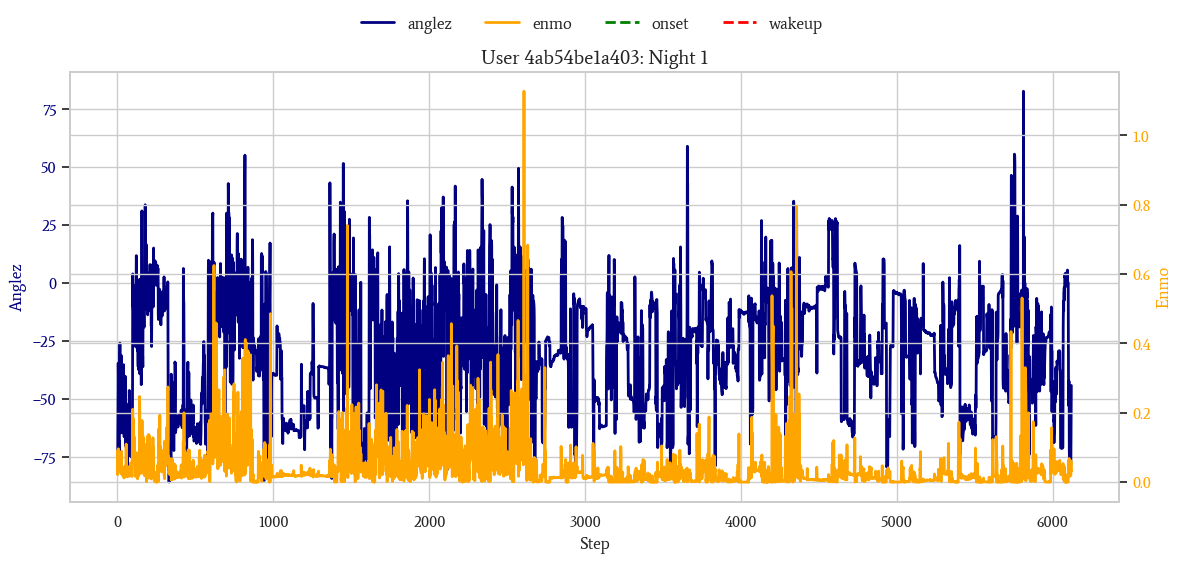

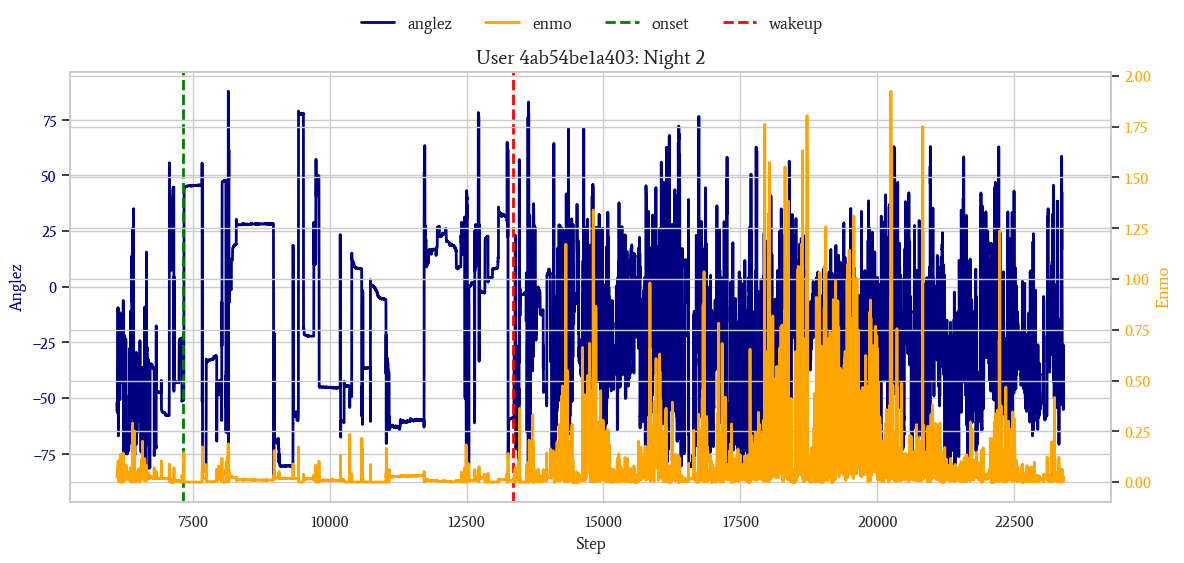

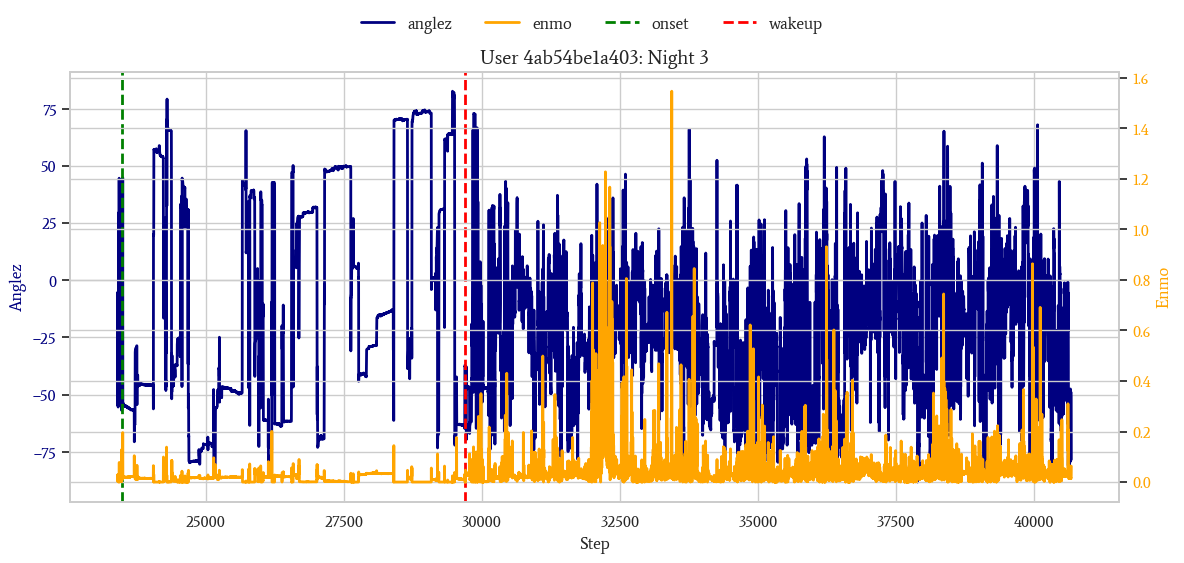

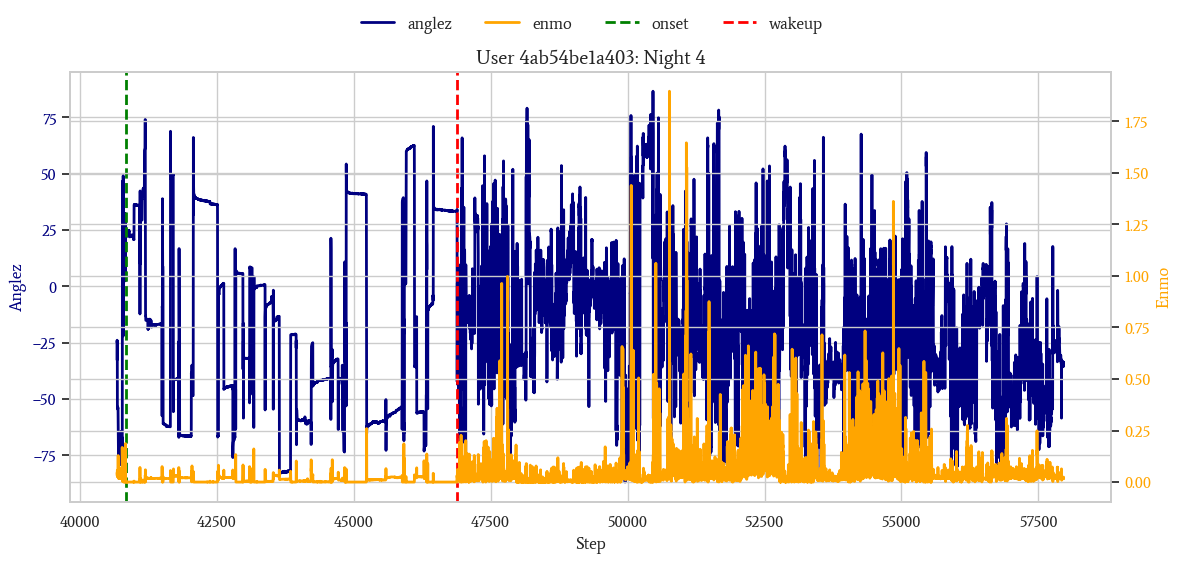

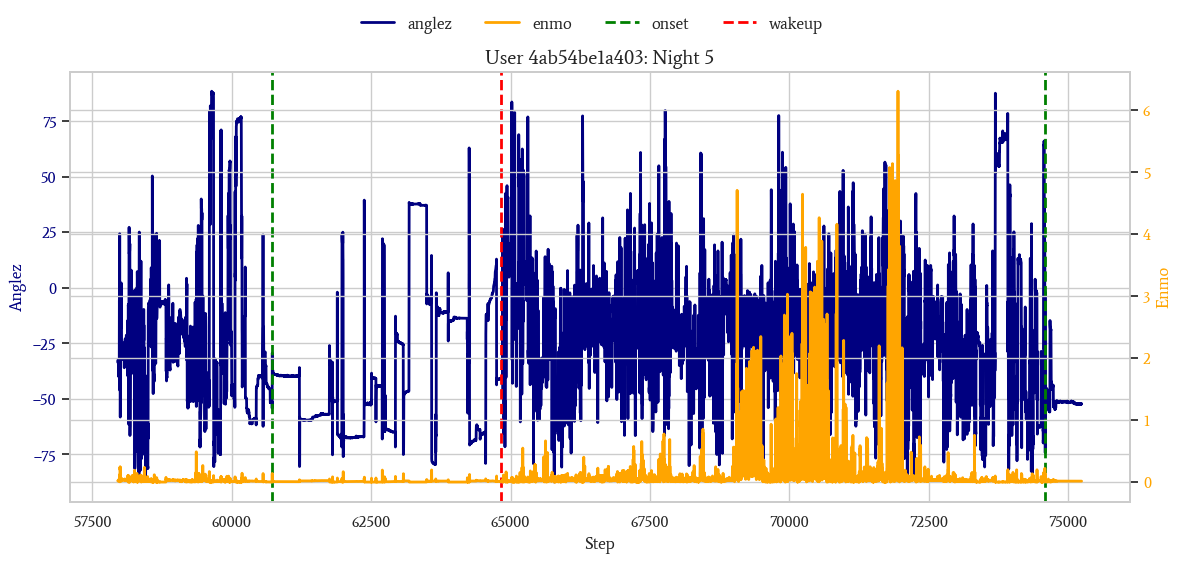

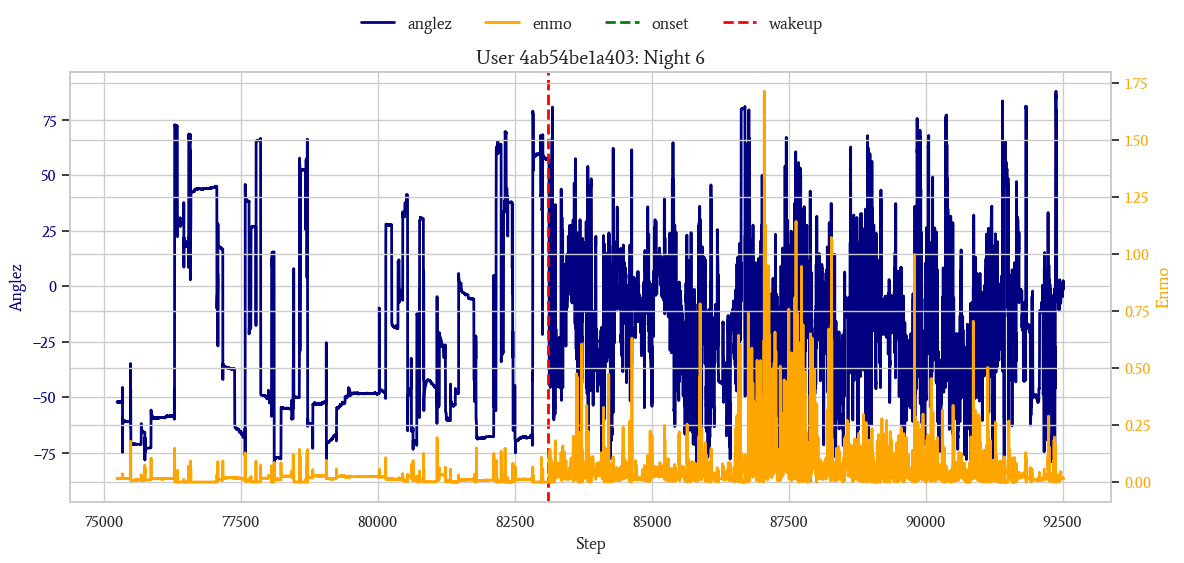

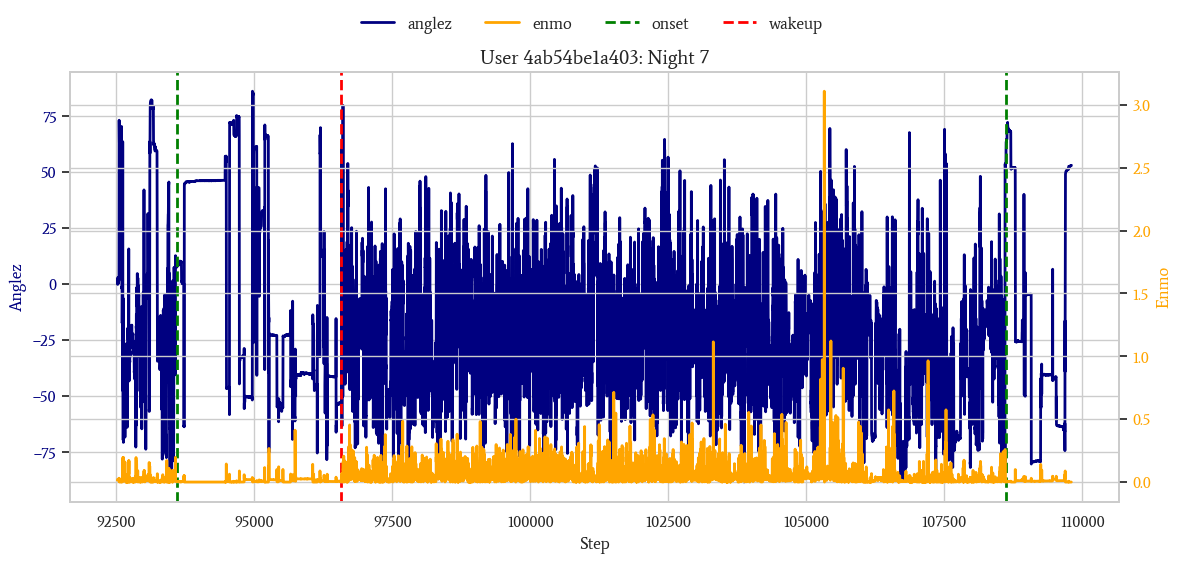

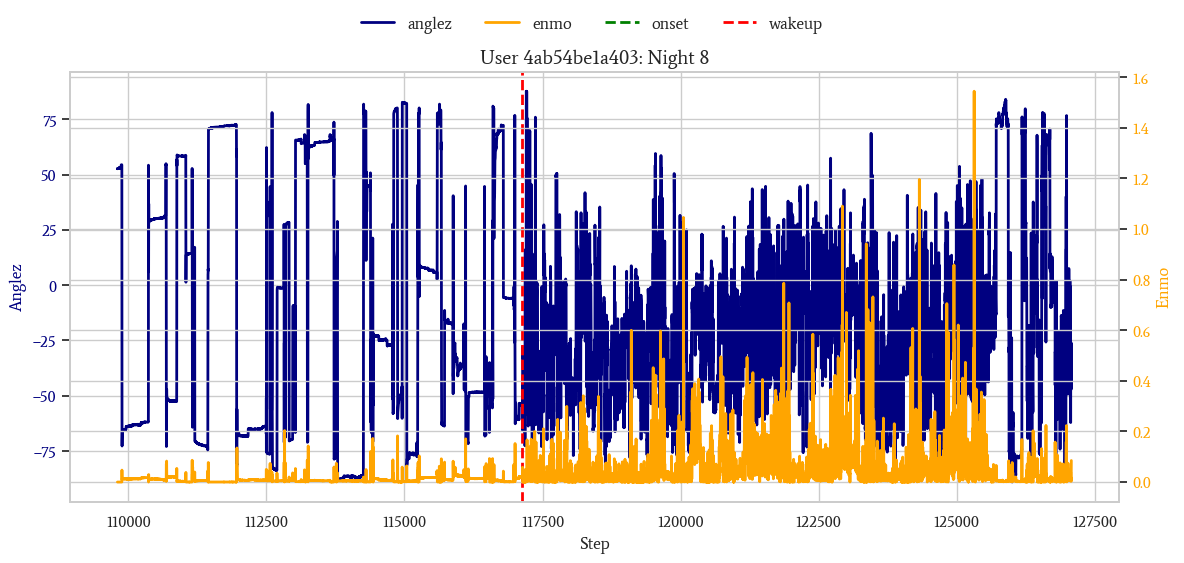

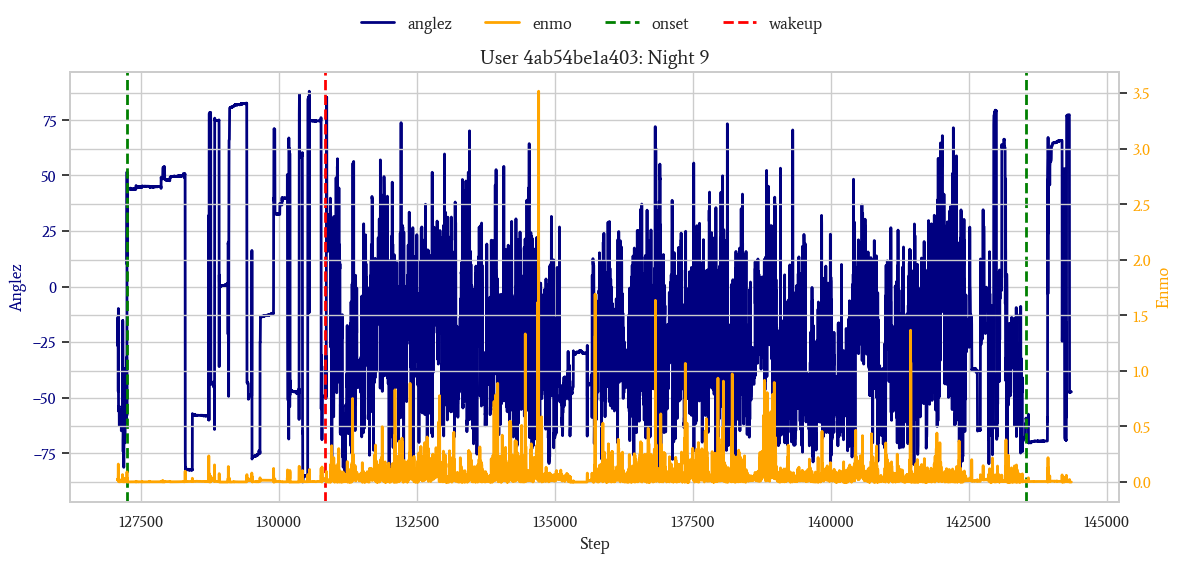

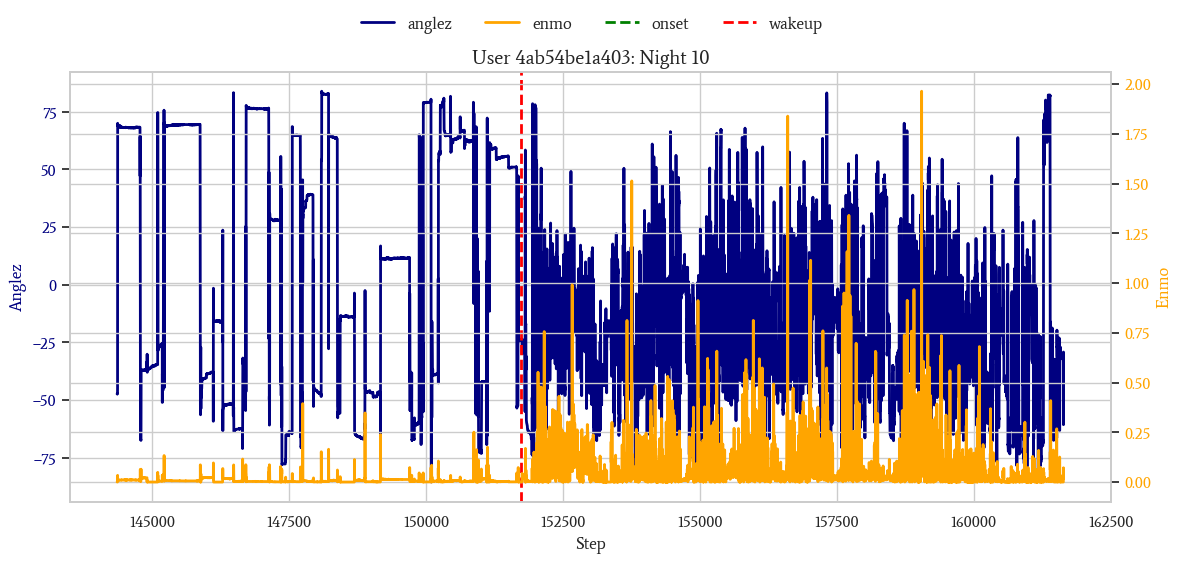

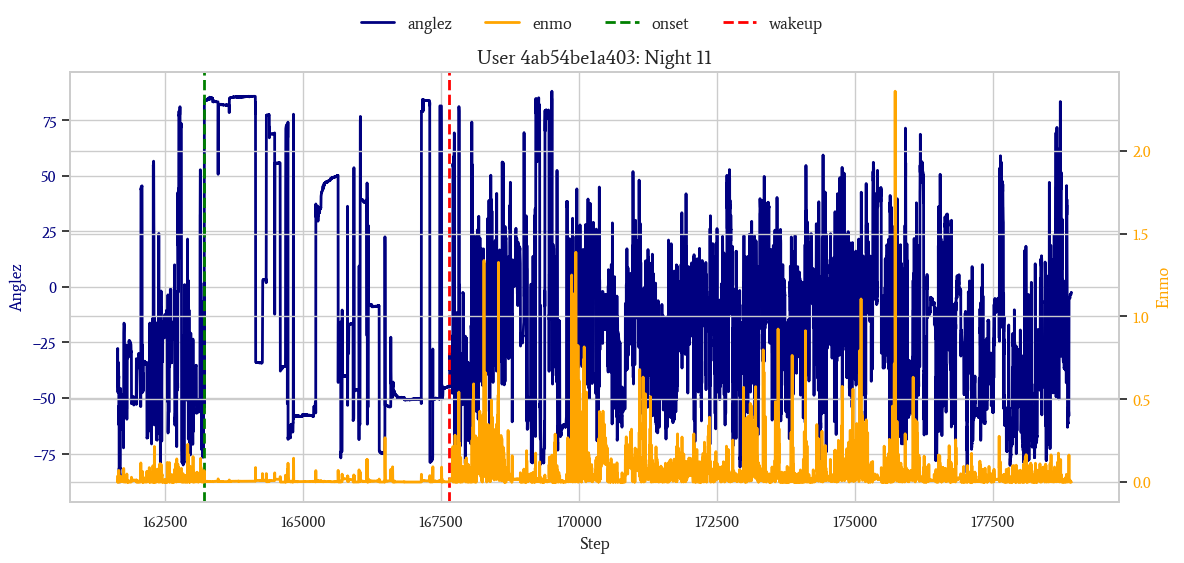

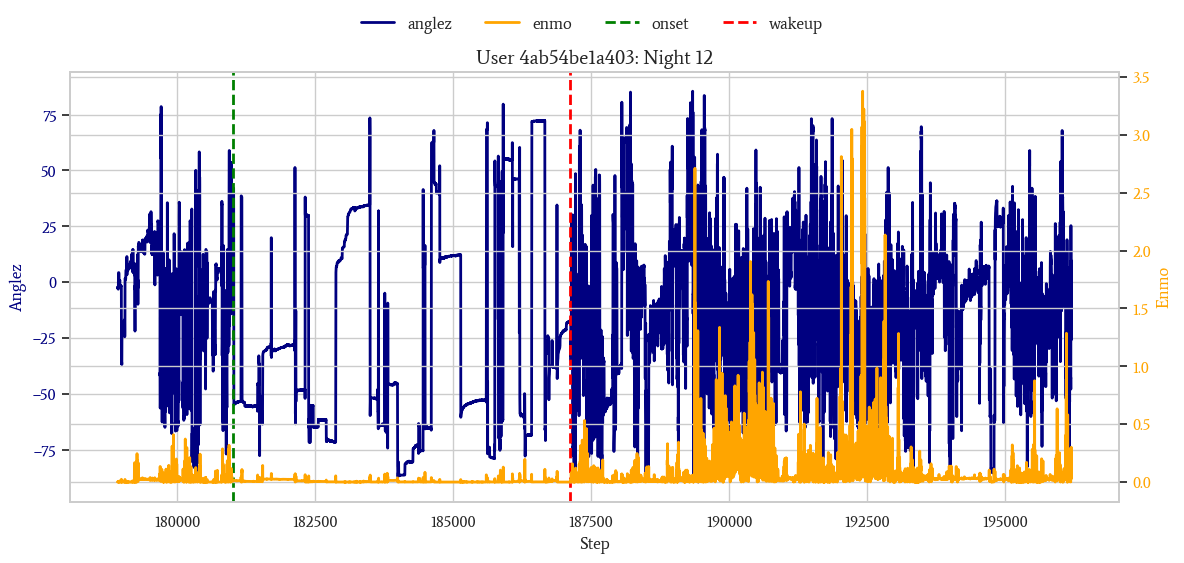

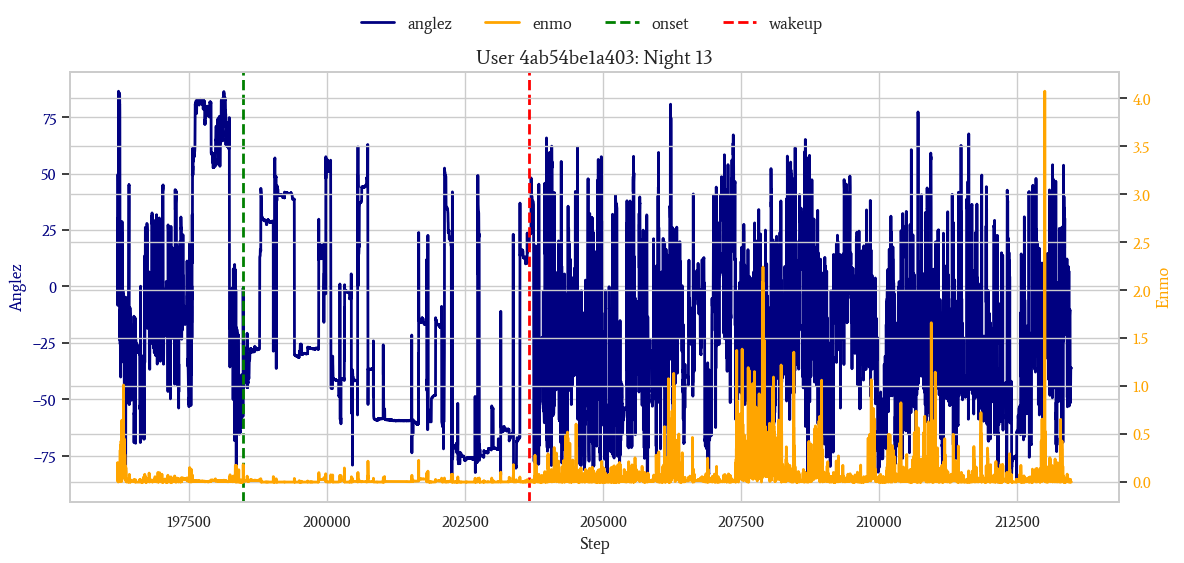

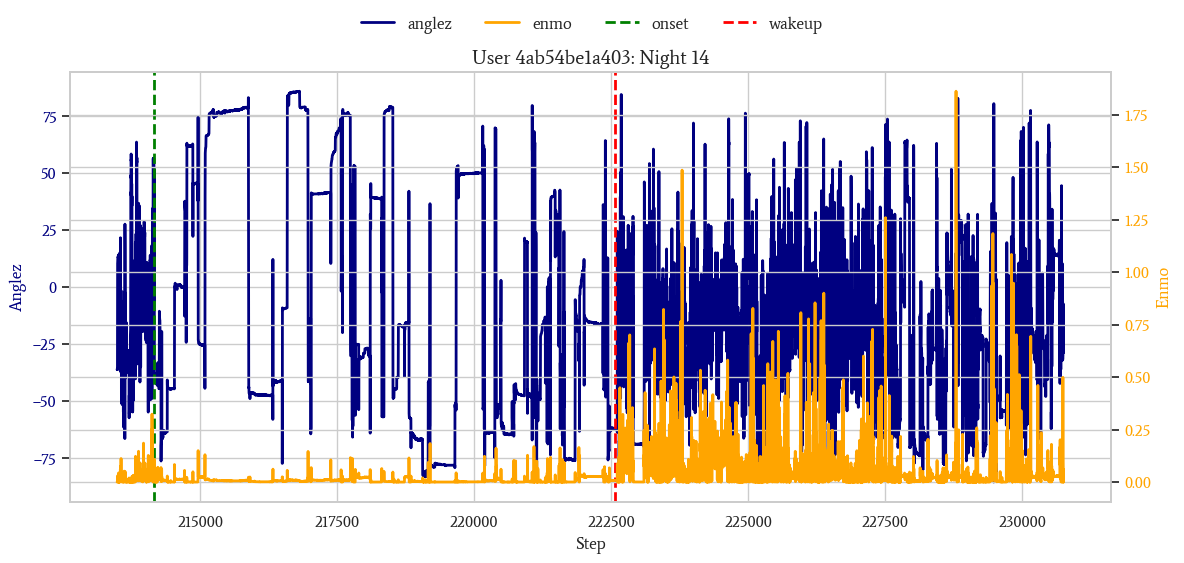

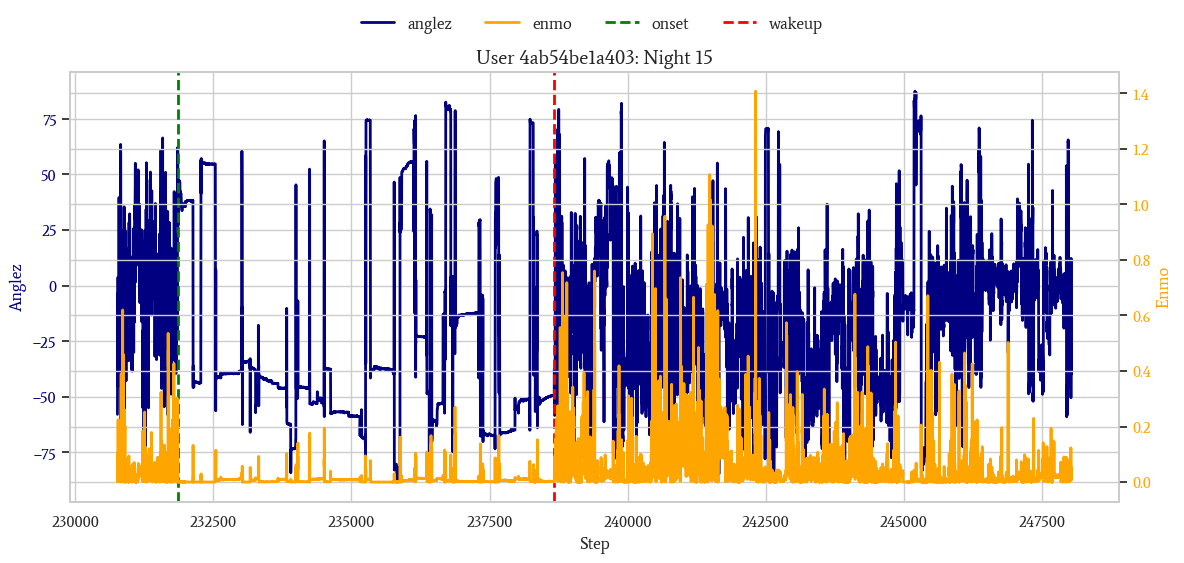

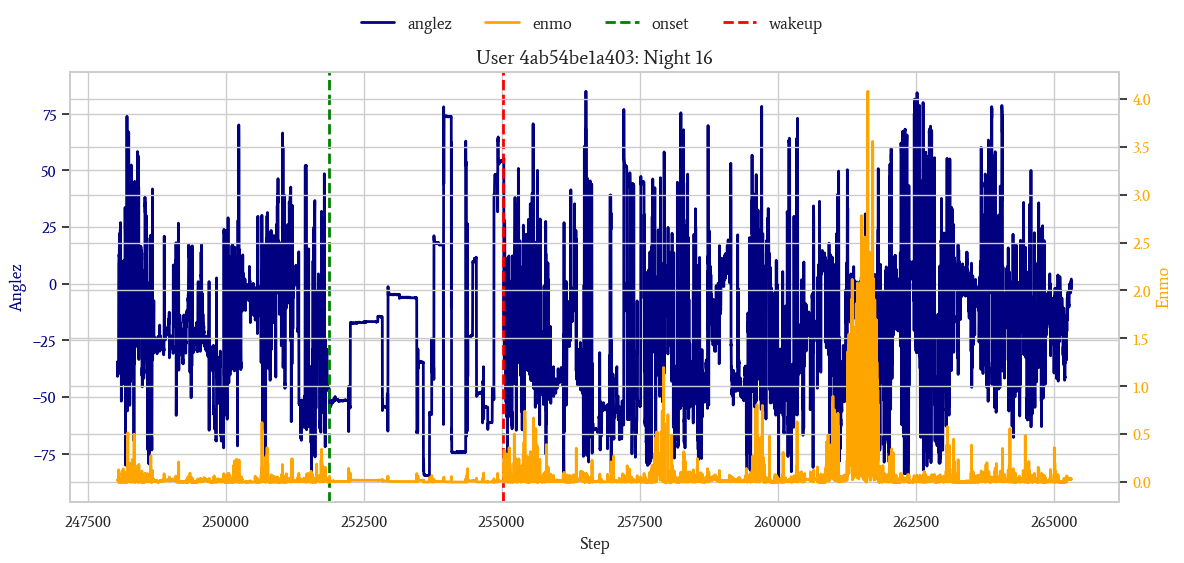

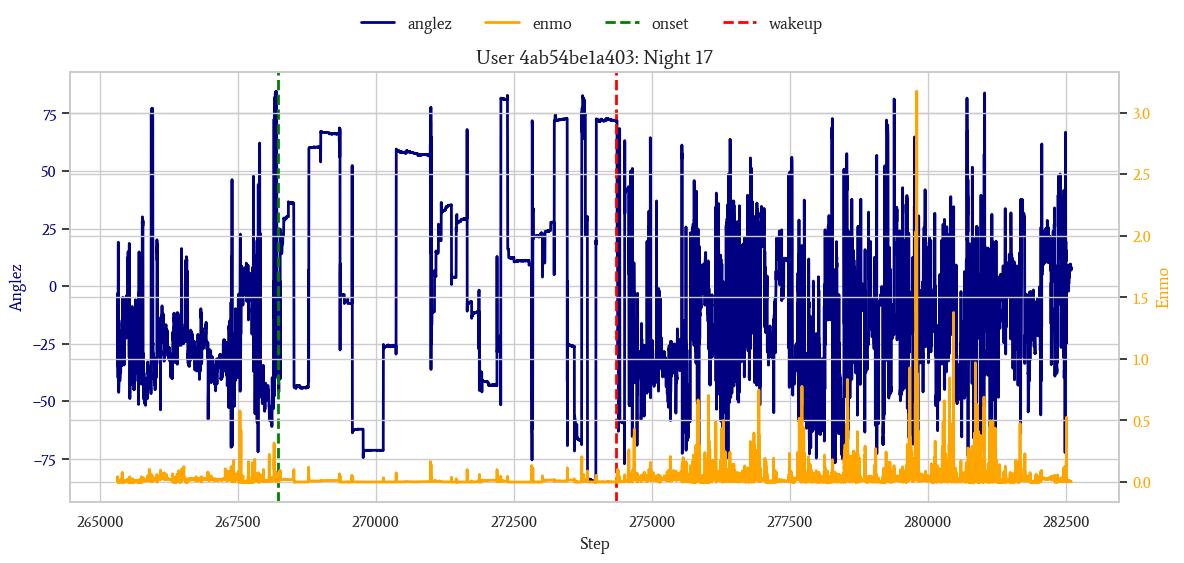

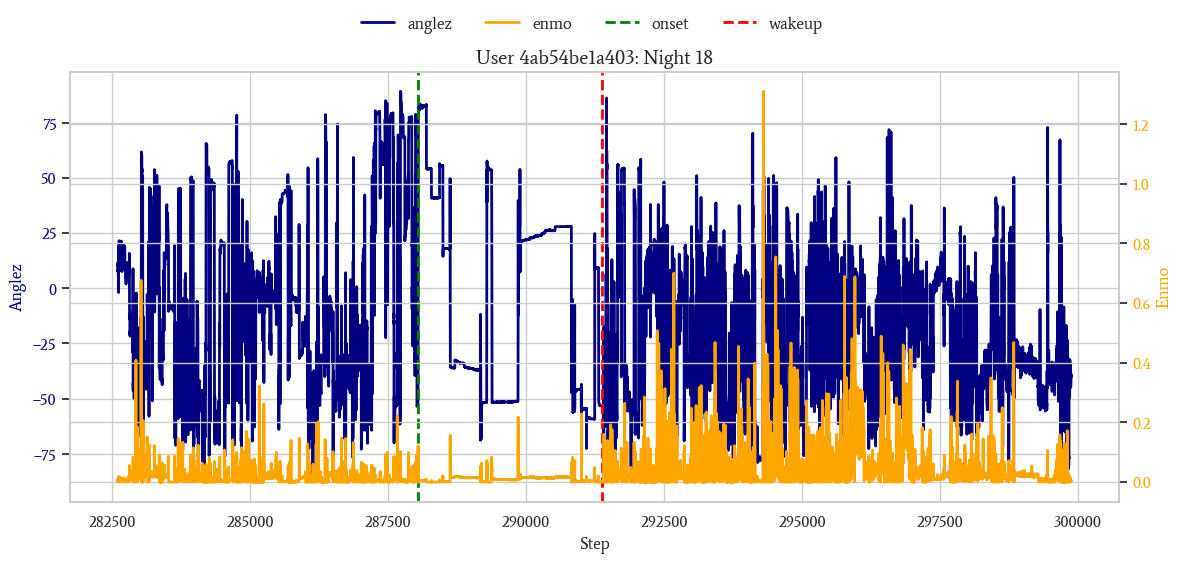

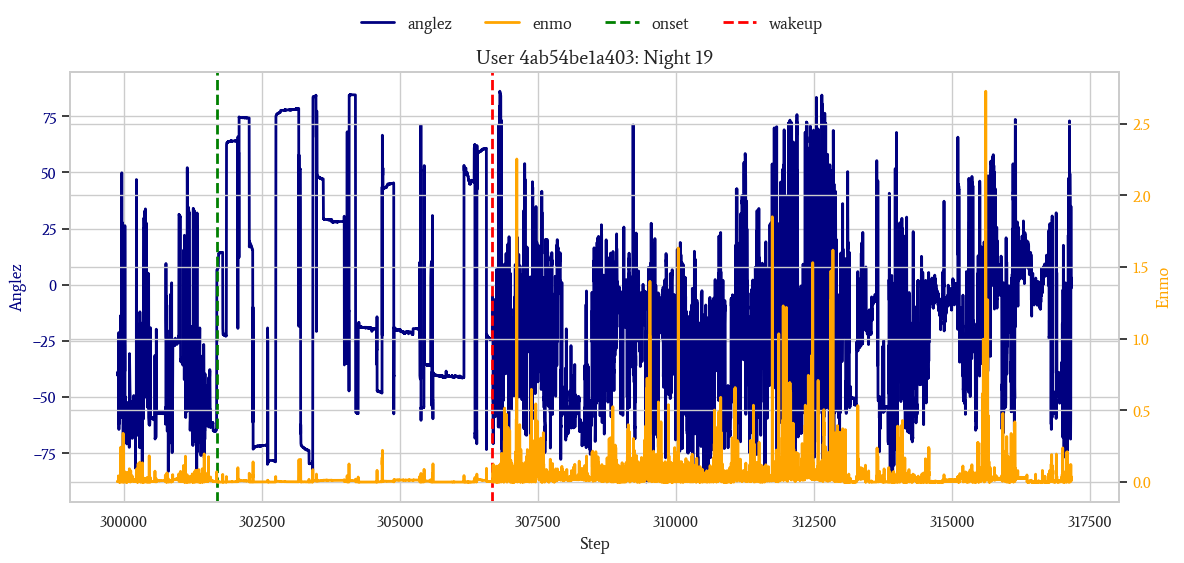

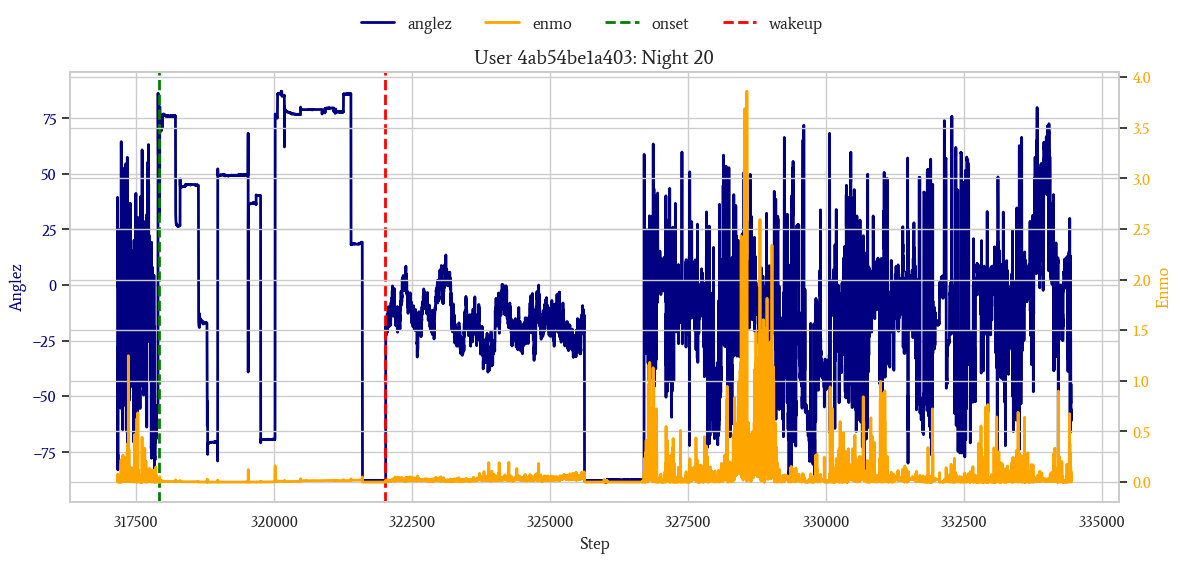

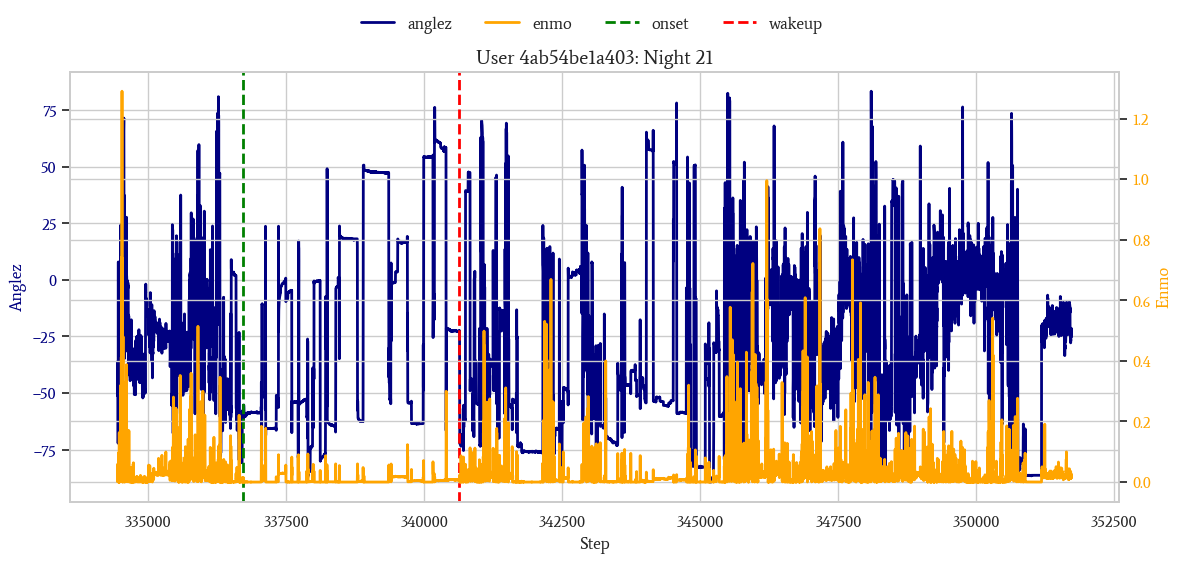

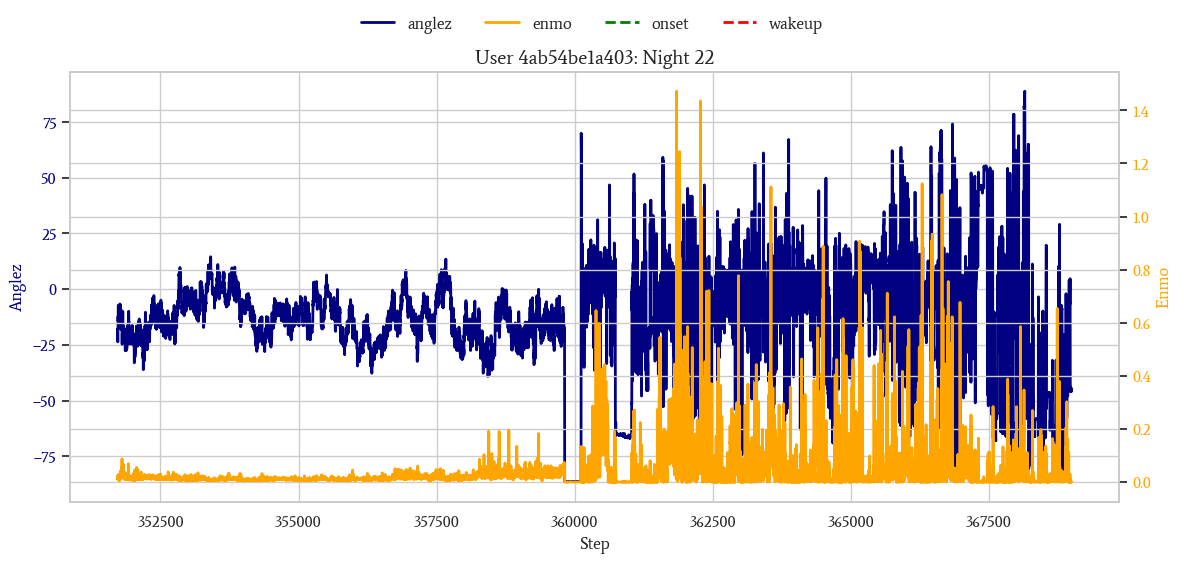

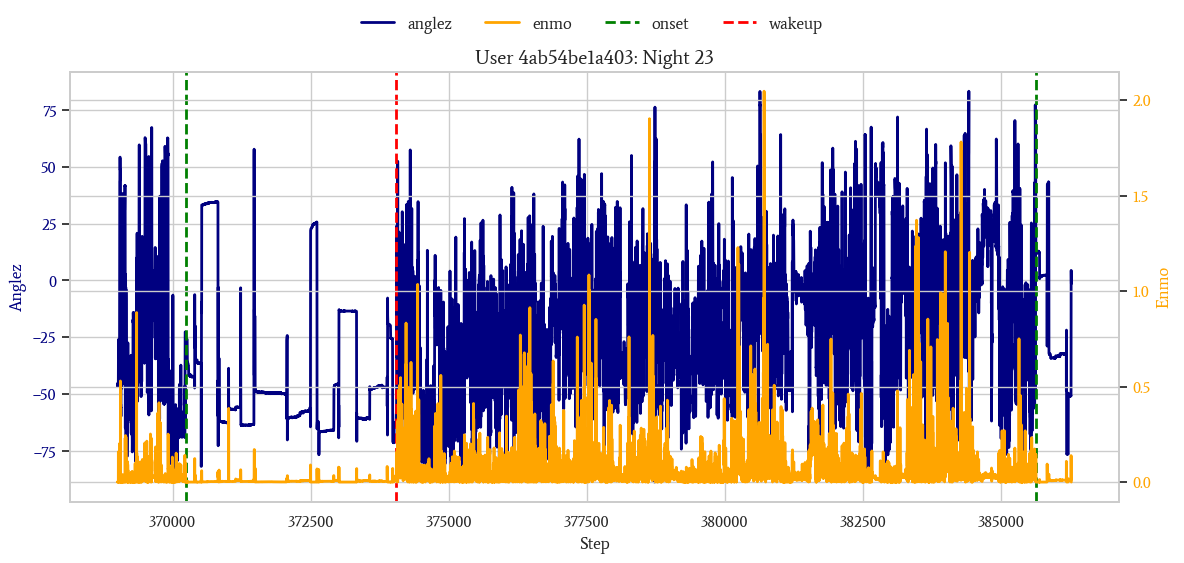

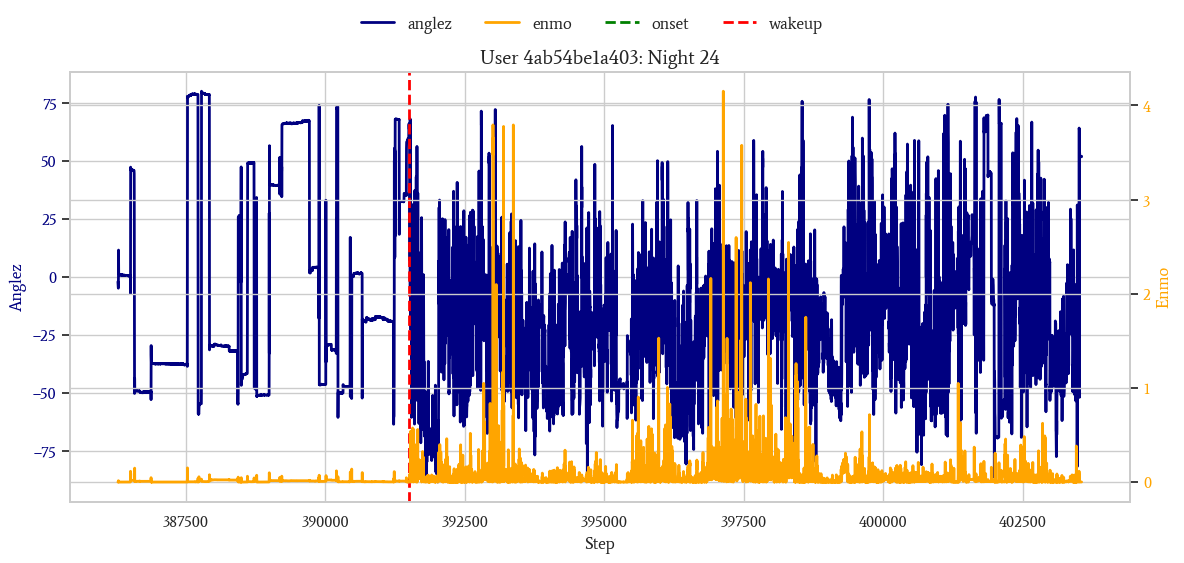

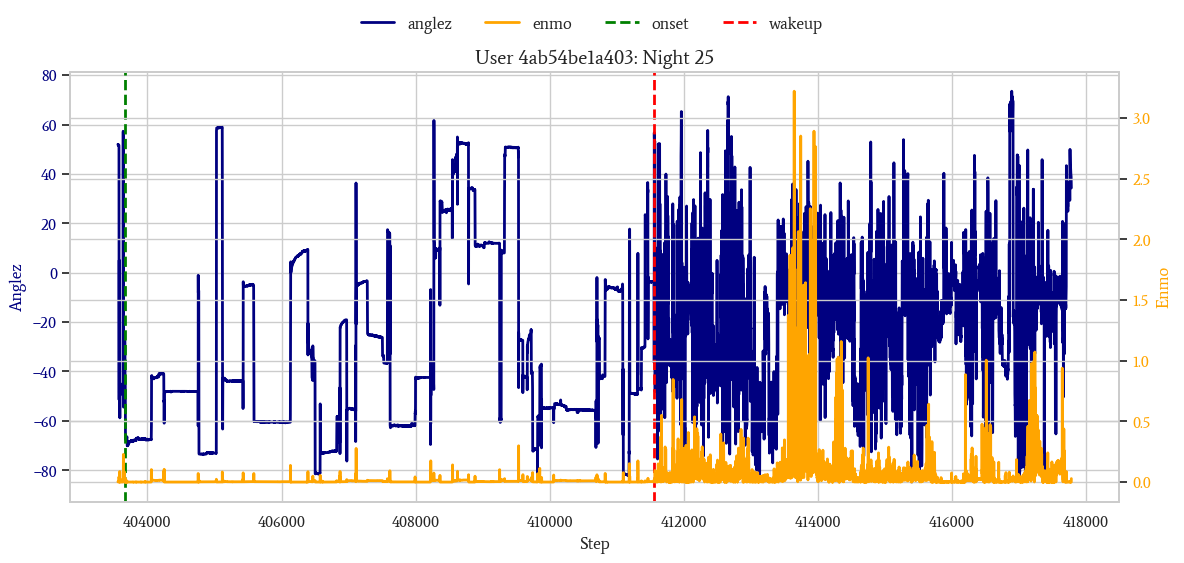

In [11]:
# get data to plot (play with this filter to see different users)
filtered_data = aggregated.filter(pl.col('tot_missing_nights') == 1)

# get a random series_id
id = get_random_id(df=filtered_data)

# get their data
user_rows = data.filter(pl.col('series_id') == id)

# plot sleep cycles for a user
plot_sleep_cycles(user_rows, events)

- During periods where the user is awake, we see that anglez has high variance and constant motion (no staircasing). Enmo (a measure of activity) is generally higher during these periods of wakefulness.
- While the user is asleep, we see that anglez has a staircase-like shape (many stretches of it being flat for hundreds of consecutive steps). Enmo is generally low  (below 0.1) 100% of the time during these times.
- In days of inactivity (with no onset/wakeup events), anglez stagnates around 0 and has a lower variance than bouts of activity.
- I'll also add differenced columns for both anglez and enmo so we can see how each fluctuates. Now, we'll analyze both sleep and awake portions.

In [5]:
# add anglez_diff and enmo_diff
data = data.with_columns([(pl.col('anglez').diff().abs().fill_null(0)).alias('anglez_diff'), (pl.col('enmo').diff().abs().fill_null(0)).alias('enmo_diff')])
test = test.with_columns([(pl.col('anglez').diff().abs().fill_null(0)).alias('anglez_diff'), (pl.col('enmo').diff().abs().fill_null(0)).alias('enmo_diff')])

# Analyze Sleep/Awake Portions

In [6]:
# label data with events
data_labeled = data.join(events[['series_id', 'step', 'event']], on=['series_id', 'step'], how='left').sort(by=['series_id', 'step'])

# split the subset
sleep, awake = split_sleep_awake_intervals(data_labeled)

# describe
print('Sleep:')
display(sleep['anglez', 'enmo', 'anglez_diff', 'enmo_diff'].describe().to_pandas().T)
print('Awake:')
display(awake['anglez', 'enmo', 'anglez_diff', 'enmo_diff'].describe().to_pandas().T)

Sleep:


,0,1,2,3,4,5,6,7,8
statistic,count,null_count,mean,std,min,25%,50%,75%,max
anglez,29838204.0,0.0,-10.128275,47.066639,-90.0,-50.4865,-18.666901,30.523399,90.0
enmo,29838204.0,0.0,0.007428,0.01831,0.0,0.0,0.0,0.0092,3.4582
anglez_diff,29838204.0,0.0,0.789645,5.382682,0.0,0.0,0.0001,0.0476,163.379303
enmo_diff,29838204.0,0.0,0.001423,0.009774,0.0,0.0,0.0,0.0002,3.1191


Awake:


,0,1,2,3,4,5,6,7,8
statistic,count,null_count,mean,std,min,25%,50%,75%,max
anglez,98108136.0,0.0,-8.409686,31.162991,-90.0,-26.623301,-8.6546,8.514,90.0
enmo,98108136.0,0.0,0.051621,0.113865,0.0,0.007,0.025,0.0554,11.4337
anglez_diff,98108136.0,0.0,6.635869,10.874971,0.0,0.4074,2.374001,7.604,171.750793
enmo_diff,98108136.0,0.0,0.028259,0.09073,0.0,0.0007,0.006,0.0233,6.9579


- We have 29m rows of sleep data and 98m rows of awake data. This ratio should be roughly 1:2 (8 hrs:16 hrs), but the awake data also contains the days when the device was not worn, slightly increasing this count.
- Anglez and Enmo were consistently lower during sleep.
- Enmo standard deviation was almost 7x higher during periods of wakefulness.

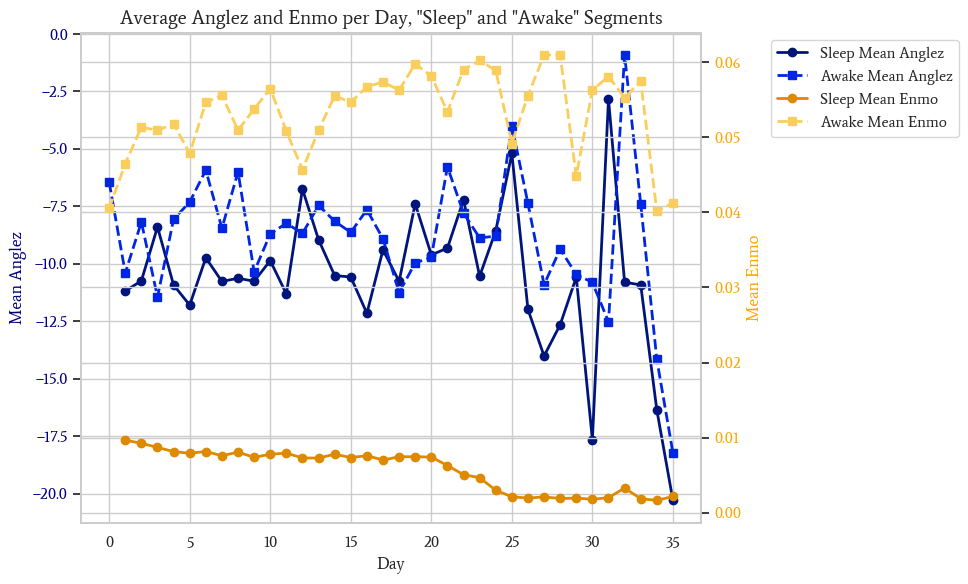

In [14]:
# plot mean anglez and enmo
plot_mean_anglez_enmo(sleep, awake)

- Anglez is similar for both sleeping and wakefulness, but is generally slightly higher while the user is awake.
- Enmo is consistently below 0.01 during sleep, and is consistenly above 0.04 during wakefulness.

# Save Data

In [7]:
# save data
data_labeled.write_parquet(root + 'train_series_clean.parquet')
test.write_parquet(root + 'test_series_clean.parquet')